In [122]:
import pandas as pd
import scipy.stats as stats
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import auc as auc
from scipy.stats import pearsonr
%matplotlib inline


In [2]:
# Read in zones and bird-beak data.
zones = pd.read_csv('zones_group_bbh.csv')
zones = zones.set_index('pat_num')
zones

,zone,group,bbh,aortic zone,pat_id,group_numeric,CD,bba
pat_num,,,,,,,,
1,2,BBG,8.6,zone-2,T1,1,1.764706,43.390292
2,2,NBBG,3.3,zone-2,T2,0,1.757614,36.603597
3,2,NBBG,1.6,zone-2,T3,0,0.986172,24.452053
4,3,BBG,6.6,zone-3,T5,1,2.058692,21.997878
5,3,BBG,5.7,zone-3,T6,1,1.190407,27.693259
6,3,NBBG,1.4,zone-3,T7,0,1.024496,25.505892
7,4,BBG,9.3,zone-4,T9,1,2.472014,41.378818
8,3,NBBG,0.8,zone-3,T10,0,1.005926,9.066720
9,2,BBG,8.9,zone-2,T11,1,1.255420,28.735107


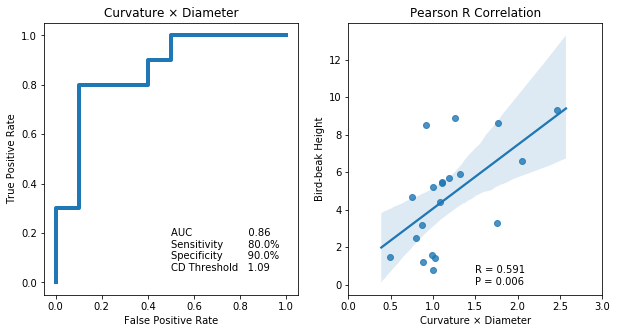

In [128]:
class BB_AUC:
    """ Plots the AUC of bird-beak height vs curvature x diameter"""
    def __init__(self, df):
        self.df = df.copy()
        
        # Change categorization to boolean
        self.df['BBG']=self.df['group']=='BBG'
        
        # Store 
        # X, Y, and threshold (t) coordinates
        self.x = []
        self.y = []
        self.t = []
        
        # Stores auc data in dataframe
        self.df_results = pd.DataFrame()
        
    def calc_auc(self):
        # Uses curvature x diameter (CD) as a threshold for diagnosing bird-beaking
        # Loop through threshold distances
        for self.threshold in range(0, 300):
            
            # If the CD is greater than the threshold,  predict bird-beaking
            self.threshold = self.threshold / 100
            self.df['predict_bb']=self.df['CD']>=self.threshold
            
            # Now check to see if prediction was correct.
            self.df_output = self.df.apply(
                self._calc_tp_tn_fp_fn,
                axis=1
            ).value_counts()
            
            # Get true positive, true negative, false negative, and false positives
            tp = self._get_item('TP')
            tn = self._get_item('TN')
            fn = self._get_item('FN')
            fp = self._get_item('FP')
            
            # Calculate true positive rate and false positive rate
            tpr = tp / (tp + fn)
            fpr = fp / (fp + tn)
            
            # Store variables
            self.x.append(fpr)
            self.y.append(tpr)
            self.t.append(self.threshold)
        self.df_results['fpr'] = self.x
        self.df_results['tpr'] = self.y
        self.df_results['cd_thresh'] = self.t
        self.df_results['specificity']=1-self.df_results['fpr']
        self.df_results['youden']=self.df_results['tpr']+self.df_results['specificity']
        return self.df_results
    
    def _get_item(self, x):
        try:
            return self.df_output.loc[x]
        except:
            return 0
    
    @staticmethod
    def _calc_tp_tn_fp_fn(x):        
        actual_bb = x['BBG']
        predict_bb = x['predict_bb']
        if predict_bb==actual_bb==True:
            return 'TP'
        elif (predict_bb==False) and (actual_bb==True):
            return 'FN'
        elif (predict_bb==True) and (actual_bb==False):
            return 'FP'
        elif predict_bb==actual_bb==False:
            return 'TN'
    def plot_roc(self, figsize=(10,5), **kwargs):
        # Plot
        _, (ax, ax2) = plt.subplots(1,2, figsize=figsize)
        ax.step(
            x=self.df_results['fpr'], 
            y=self.df_results['tpr'], 
            **kwargs
        )
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        
        # AUC
        auc_result = auc(self.df_results['fpr'], self.df_results['tpr'])
        summary = self.df_results.iloc[self.df_results['youden'].idxmax()]
        sensitivity = summary.loc['tpr']
        specificity = summary.loc['specificity']
        cutoff = summary.loc['cd_thresh']
        
        # Print on chart
        txt = "AUC {:>21}\nSensitivity {:>11}%\nSpecificity {:>11}%\nCD Threshold {:>6}\n".format(
            auc_result,
            sensitivity * 100,
            specificity * 100,
            cutoff
        )
        ax.text(.5,0,txt)
        ax.set_title('Curvature × Diameter')
        sns.regplot(data=self.df, x='CD', y='bbh', ax=ax2)
        r, p = pearsonr(self.df['CD'], self.df['bbh'])
        ax2.text(1.5, 0, "R = {:.3f}\nP = {:.3f}".format(r,p))
        ax2.set_ylabel('Bird-beak Height')
        ax2.set_xlabel('Curvature × Diameter')
        ax2.set_title('Pearson R Correlation')
        ax2.set_xlim([0,3])
        #self.df.plot(kind='scatter', x='CD', y='bbh', ax=ax2)

bb_auc = BB_AUC(zones)
bb_auc.calc_auc()
bb_auc.plot_roc(linewidth=4)
plt.savefig('roc_cd_threshold.png', dpi=400)
